In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

Из домашек

In [3]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [4]:
transform = Compose([Resize((32, 32)), ToTensor()])
data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
#data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./ColoredMNIST/raw/train-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting ./ColoredMNIST/raw/train-labels-idx1-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./ColoredMNIST/raw/t10k-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.01MB/s]

Extracting ./ColoredMNIST/raw/t10k-labels-idx1-ubyte.gz to ./ColoredMNIST/raw



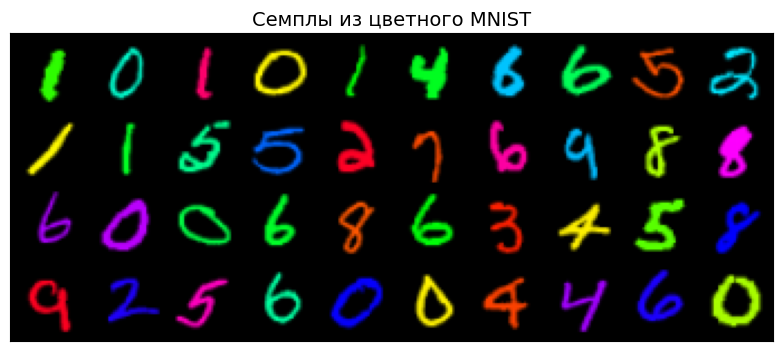

In [5]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

visualize_batch(next(iter(train_dataloader))[0][:40])

Будем переделывать 5 в 6

In [23]:
train_5=[img for img,label in data_train if label==5]
train_5_loader = DataLoader(train_5, batch_size=64, shuffle=True)

train_6=[img for img,label in data_train if label==6][:len(train_5)]
train_6_loader = DataLoader(train_6, batch_size=64, shuffle=True)

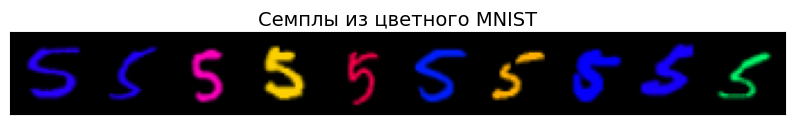

In [7]:
visualize_batch(next(iter(train_5_loader))[0][:10])

Воспользуемся идеей paired_dataloader

In [32]:
from torch.utils.data import Dataset, DataLoader

def paired_dataloader(dataset_0, dataset_1, batch_size):
    assert len(dataset_0) == len(dataset_1)
    idx = 0
    data_len = len(dataset_0)
    while True:
        if idx + batch_size > data_len:
            yield dataset_0[:batch_size], dataset_1[:batch_size]
            idx = batch_size
        else:
            yield dataset_0[idx:idx + batch_size], dataset_1[idx:idx + batch_size]
            idx += batch_size

In [33]:
paired_dataloader_5_6 = paired_dataloader(train_5, train_6, 64)

In [10]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Возьмем всю ту же модель EDM

In [11]:
!git clone https://github.com/NVlabs/edm

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [12]:
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')

import pickle
from edm.dnnlib import util
#from torch_utils import misc

from edm.training.networks import EDMPrecond
from edm.training.loss import EDMLoss

In [86]:
net = EDMPrecond(img_resolution=32,img_channels=3, label_dim=10).to('cuda')
opt = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=0.001)
#opt = torch.optim.Adam(net.parameters(), lr=5e-4)
print(f'Network has {sum(p.numel() for p in net.parameters())} parameters')

Network has 279631875 parameters


И будем учить OT-CFM

In [14]:
!pip install pot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 20.2 MB/s eta 0:00:00


In [34]:
next(iter(paired_dataloader_5_6))

([tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.

In [87]:
# OT-CFM
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import ot as pot
from functools import partial
import numpy as np
batch_size = 32

def training_loop_ot(net, opt, dataloader, num_epochs=10000):
    net.train()
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        opt.zero_grad()
        data = next(iter(dataloader))
        x1 = torch.stack(data[1]).to('cuda')
        y = torch.tensor([6]).repeat(x1.shape[0])
        x0 = torch.stack(data[0]).to('cuda')

        # сэпмлим рандомно от 0 до 1

        ot_fn = partial(pot.sinkhorn, reg=0.05)

        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        x0 = x0.reshape(x0.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        p = ot_fn(a, b, M.detach().cpu().numpy())
        if np.abs(p.sum()) < 1e-8:
            p = np.ones_like(p) / p.size

        pi = p
        p = p.flatten()
        p = p / p.sum()
        choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        i, j = np.divmod(choices, pi.shape[1])
        x0 = x0[i]
        x1 = x1[j]
        y1 = y[j]

        #t, xt, ut = super().sample_location_and_conditional_flow(x0, x1, t, return_noise)
        x1=x1.reshape(32,3,32,32)
        x0=x0.reshape(32,3,32,32)

        #batch_size = x0.shape[0]
        t = torch.rand(x0.shape[0], device=x0.device)
        t = t.reshape(-1, *([1] * (x0.dim() - 1)))
     #  print(t)
        x_t = x0 + (x1 - x0) * t
        new_labels = torch.eye(10)[y1]
     #   print(x_t.shape, t.shape, y1.shape)
        f_x_t = net(x_t, t, class_labels=new_labels.to('cuda'))
        loss = ((f_x_t - (x1 - x0)) ** 2).mean()

        loss.backward()
        clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()
        pbar.set_description(f'Loss: {loss.item()}')
        if loss.item() > 2:
          print("!!!!!")
        history_ot.append(loss.item())

In [91]:
#history_ot=[]
training_loop_ot(net, opt, paired_dataloader_5_6, num_epochs=2000)

Loss: 0.014677184633910656: 100%|██████████| 2000/2000 [40:09<00:00,  1.20s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

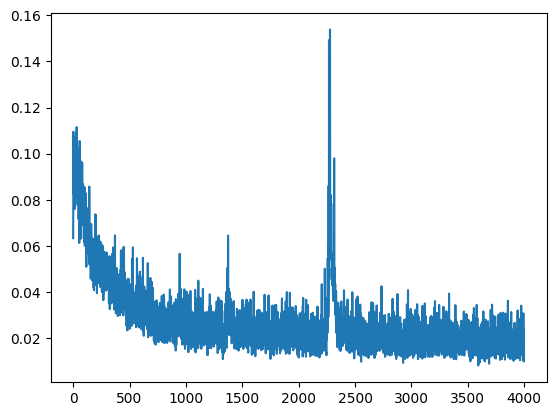

In [92]:
import matplotlib.pyplot as plt
plt.plot(history_ot)
plt.show

Всё так же MSE. Да, взорвался посередине несмотря на наш буфер в виде weight_decay

In [117]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def visualize_batch(img_vis, title='Семплы', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

def solve_euler(f, x_0, class_labels, n_steps_vis=10, n_steps_per_vis=10, eps=1e-3, return_history=True):

    n_steps = n_steps_vis * n_steps_per_vis
    t_values = torch.linspace(eps, 1.0 - eps, n_steps + 1, device='cuda') #, device='cuda')
    t_diffs = t_values[1:] - t_values[:-1]
    x_t = x_0

    with torch.no_grad(): #
        for step_vis in range(n_steps_vis):
            for inner_step in range(n_steps_per_vis):
                step = step_vis * n_steps_per_vis + inner_step
                t = torch.ones(x_t.shape[0], device='cuda') * t_values[step]
                h = t_diffs[step]
                x_t = x_t + h * f(x_t, t[:, None], class_labels=torch.tensor([0,0,0,0,0,1,0,0,0,0]).to('cuda'))

    return x_t



def visualize_model_samples(model, index, params=[], labels_usage='dummy', class_labels=None, title='Семплы из модели', num_sampled=5, **model_kwargs):
    noise = train_5[index].to('cuda') #, device=params['device'])
    # if class_labels is None and labels_usage == 'dummy':
    #     class_labels = torch.zeros(40, 10) #, device=params['device'])
    #     # class_labels[:, -1] = 1
    # # elif labels_usage == 'random':

    out = solve_euler(model, noise, class_labels=class_labels, **model_kwargs)
    print(out.shape)
    visualize_batch(noise.detach().cpu(), title=title)
    visualize_batch(out.detach().cpu(), title=title)

torch.Size([3, 3, 32, 32])


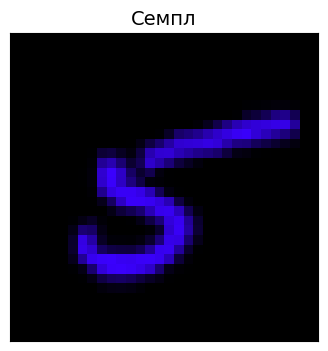

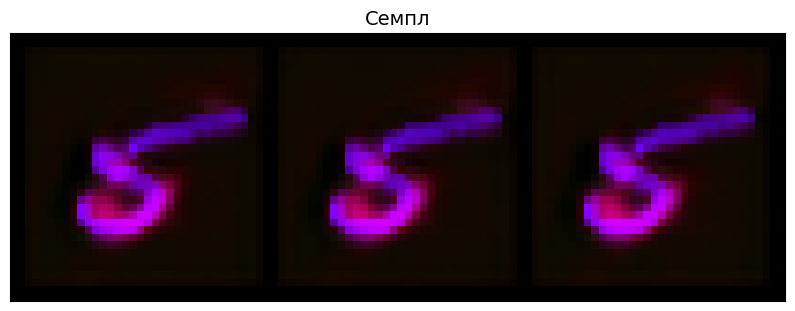

In [118]:
visualize_model_samples(net, index=8, labels_usage='dummy', title='Семпл')

torch.Size([3, 3, 32, 32])


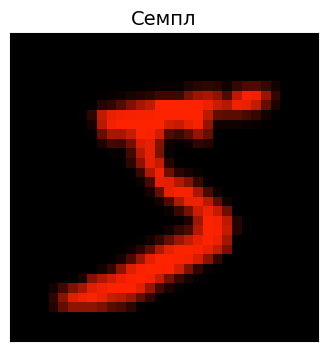

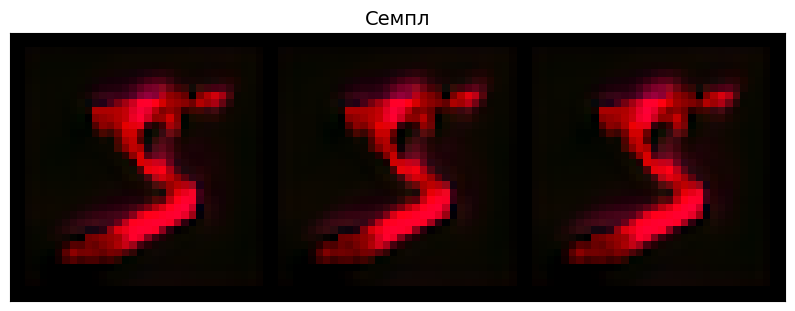

In [119]:
visualize_model_samples(net, index=0, labels_usage='dummy', title='Семпл')

Уверены, что результат был бы лучше, если бы в качестве условия брали цвет цифры, но не придумали, как это аккуратно реализовать. Тем не менее видно, что модель работает на закругление и стирает слишком длинные хвосты пятёрок